# Purpose
The purpose of this notebook is two-fold. In it, I aim to:
1. Reproduce the MNL model used in "Brownstone, Davide and Train, Kenneth (1999). 'Forecasting new product penetration with flexible substitution patterns'. Journal of Econometrics 89: 109-129." (p. 121).
2. 'Check' the MNL model for lack-of-fit between observable features of the data and predictions from the model.
3. Produce 7 plots to illustrate the general model-checking procedure.
4. Test and prototype the use of extremely randomized trees and bagged tree ensembles for scatterplot smoothing.


In [1]:
import sys
from collections import OrderedDict

import scipy.stats
import pandas as pd
import numpy as np

import pylogit as pl

sys.path.insert(0, '../src')
from visualization import predictive_viz as viz

%matplotlib inline

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load the car data

In [2]:
car_df = pd.read_csv("../data/processed/model_ready_car_data.csv")

# Create the utility specification

In [3]:
car_mnl_spec, car_mnl_names = OrderedDict(), OrderedDict()

cols_and_display_names =\
    [('price_over_log_income', 'Price over log(income)'),
     ('range_over_100', 'Range (units: 100mi)'),
     ('acceleration_over_10', 'Acceleration (units: 0.1sec)'),
     ('top_speed_over_100', 'Top speed (units: 0.01mph)'),
     ('pollution', 'Pollution'),
     ('vehicle_size_over_10', 'Size'),
     ('big_enough', 'Big enough'),
     ('luggage_space', 'Luggage space'),
     ('tens_of_cents_per_mile', 'Operation cost'),
     ('station_availability', 'Station availability'),
     ('sports_utility_vehicle', 'Sports utility vehicle'),
     ('sports_car', 'Sports car'),
     ('station_wagon', 'Station wagon'),
     ('truck', 'Truck'),
     ('van', 'Van'),
     ('electric', 'EV'),
     ('electric_commute_lte_5mi', 'Commute < 5 & EV'),
     ('electric_and_college', 'College & EV'),
     ('compressed_natural_gas', 'CNG'),
     ('methanol', 'Methanol'),
     ('methanol_and_college', 'College & Methanol')]
    
for col, display_name in cols_and_display_names:
    car_mnl_spec[col] = 'all_same'
    car_mnl_names[col] = display_name


# Estimate the MNL model

In [4]:
# Initialize the mnl model
car_mnl = pl.create_choice_model(data=car_df,
                                 alt_id_col='alt_id',
                                 obs_id_col='obs_id',
                                 choice_col='choice',
                                 specification=car_mnl_spec,
                                 model_type='MNL',
                                 names=car_mnl_names)

# Create the initial variables for model estimation
num_vars = len(car_mnl_names)
initial_vals = np.zeros(num_vars)

# Estimate the mnl model
fit_vals = car_mnl.fit_mle(initial_vals,
                           method='L-BFGS-B',
                           just_point=True)['x']
# Note ridge=1e-7 produces the same results as non-regularized MLE
car_mnl.fit_mle(fit_vals, method='BFGS')

# Look at the estimation results
car_mnl.get_statsmodels_summary()

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)


Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -7,391.8638
Estimation Time for Point Estimation: 0.19 seconds.
Final log-likelihood: -7,391.8300


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:507: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,654
Model:             Multinomial Logit Model   Df Residuals:                    4,633
Method:                                MLE   Df Model:                           21
Date:                     Sun, 23 Dec 2018   Pseudo R-squ.:                   0.114
Time:                             01:46:12   Pseudo R-bar-squ.:               0.111
AIC:                            14,825.660   Log-Likelihood:             -7,391.830
BIC:                            14,961.015   LL-Null:                    -8,338.849
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Price over log(income)          -0.1854      0.027     -6.796      0.000      -0.239      -0.132
Range (units: 100mi)             0.3501      0.027     13.052      0.000       0.298       0.403
Acceleration (units: 0.1sec)    -0.7160      0.111     -6.472      0.000      -0.933      -0.499
Top speed (units: 0.01mph)       0.2612      0.081      3.228      0.001       0.103       0.420
Pollution                       -0.4441      0.102     -4.367      0.000      -0.643      -0.245
Size                             0.9345      0.316      2.953      0.003       0.314       1.555
Big enough                       0.1432      0.077      1.853      0.064      -0.008       0.295
Luggage space                    0.5009      0.191      2.623      0.009       0.127       0.875
Operation cost                  -0.7679      0.076    -10.131      0.000      -0.916      -0.619
Station availability             0.4133      0.096      4.294      0.000       0.225       0.602
Sports utility vehicle           0.8201      0.141      5.830      0.000       0.544       1.096
Sports car                       0.6370      0.148      4.298      0.000       0.347       0.928
Station wagon                   -1.4367      0.062    -23.139      0.000      -1.558      -1.315
Truck                           -1.0168      0.049    -20.753      0.000      -1.113      -0.921
Van                             -0.7989      0.047    -16.864      0.000      -0.892      -0.706
EV                              -0.1786      0.172     -1.041      0.298      -0.515       0.158
Commute < 5 & EV                 0.1983      0.084      2.374      0.018       0.035       0.362
College & EV                     0.4426      0.109      4.058      0.000       0.229       0.656
CNG                              0.3450      0.092      3.744      0.000       0.164       0.526
Methanol                         0.3134      0.103      3.051      0.002       0.112       0.515
College & Methanol               0.2284      0.089      2.576      0.010       0.055       0.402
================================================================================================
"""

In [5]:
print(np.round(pd.concat([car_mnl.params,
                    car_mnl.standard_errors],
                   axis=1),
               decimals=3).to_latex())

\begin{tabular}{lrr}
\toprule
{} &  parameters &  std\_err \\
\midrule
Price over log(income)       &      -0.185 &    0.027 \\
Range (units: 100mi)         &       0.350 &    0.027 \\
Acceleration (units: 0.1sec) &      -0.716 &    0.111 \\
Top speed (units: 0.01mph)   &       0.261 &    0.081 \\
Pollution                    &      -0.444 &    0.102 \\
Size                         &       0.934 &    0.316 \\
Big enough                   &       0.143 &    0.077 \\
Luggage space                &       0.501 &    0.191 \\
Operation cost               &      -0.768 &    0.076 \\
Station availability         &       0.413 &    0.096 \\
Sports utility vehicle       &       0.820 &    0.141 \\
Sports car                   &       0.637 &    0.148 \\
Station wagon                &      -1.437 &    0.062 \\
Truck                        &      -1.017 &    0.049 \\
Van                          &      -0.799 &    0.047 \\
EV                           &      -0.179 &    0.172 \\
Commute < 5 \& EV

# Replication Results

The original modeling results have been replicated. To do so, I needed to change the vehicle fuel types in the mlogit data to correct a likely transcription error.

# MNL Model Checking

In [6]:
# Simulate values from the sampling distribution of coefficients
cov_matrix = np.linalg.inv(-1 * car_mnl.hessian)
mnl_sampling_dist =\
    scipy.stats.multivariate_normal(mean=car_mnl.params.values,
                                    cov=cov_matrix)

In [7]:
# Take Draws from the sampling distribution
num_draws = 1000
np.random.seed(325)
simulated_coefs = mnl_sampling_dist.rvs(num_draws)
simulated_coefs.shape

(1000, 21)

In [8]:
# Predict the model probabilities
simulated_probs =\
    car_mnl.predict(car_df,
                    param_list=[simulated_coefs.T, None, None, None])

# Simulate y from the sampling distribution
likelihood_sim_y =\
    viz.simulate_choice_vector(simulated_probs,
                               car_df['obs_id'].values,
                               rseed=1122018)

Simulating Choices: 100%|██████████| 4654/4654 [00:00<00:00, 4760.01it/s]


# Make the seven desired plots

In [9]:
import seaborn as sbn
import matplotlib.pyplot as plt

### 1. Log-Likelihood plot

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


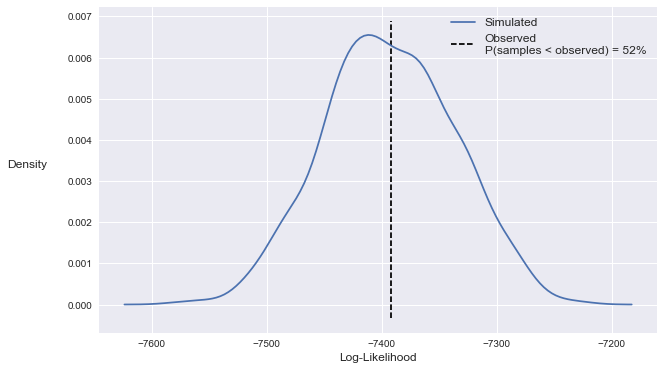

In [10]:
reload(viz)

sim_log_likes =\
    viz.compute_prior_predictive_log_likelihoods(likelihood_sim_y,
                                                 car_df,
                                                 "choices",
                                                 car_mnl)

# log_like_path = '../reports/figures/log-predictive-vehicle-choice-mnl.pdf'
log_like_path = None
viz.plot_predicted_log_likelihoods(sim_log_likes,
                                   car_mnl.llf,
                                   output_file=log_like_path)

### 2. Outcome Boxplot

Unique x-values: 100%|██████████| 4/4 [00:00<00:00, 22.70it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


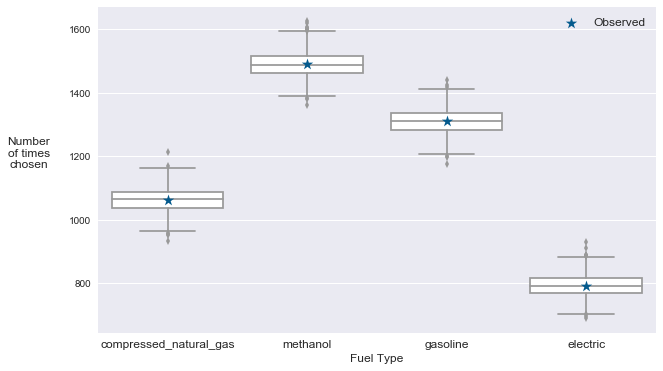

In [11]:
reload(viz)
market_path = None

market_dict = dict(cng='compressed_natural_gas')

viz.plot_simulated_market_shares(car_df.fuel_type.values,
                                 likelihood_sim_y,
                                 car_df.choice.values,
                                 x_label='Fuel Type',
                                 y_label='Number\nof times\nchosen',
                                 display_dict=market_dict,
                                 output_file=market_path)

Unique x-values: 100%|██████████| 6/6 [00:00<00:00, 33.02it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


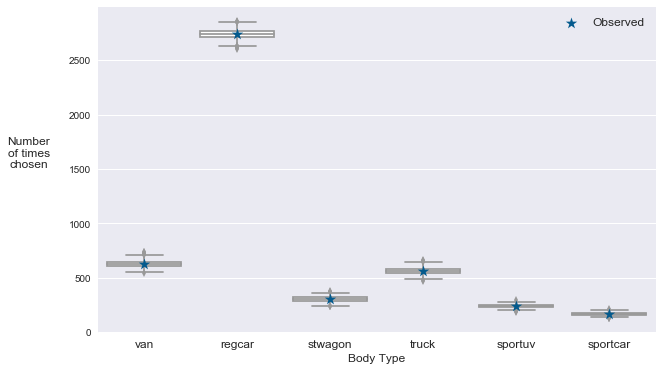

In [12]:
reload(viz)
viz.plot_simulated_market_shares(car_df.body_type.values,
                                 likelihood_sim_y,
                                 car_df.choice.values,
                                 x_label='Body Type',
                                 y_label='Number\nof times\nchosen')

### 3. Binned Reliability Plot

Plotting: 100%|██████████| 1/1 [00:00<00:00, 97.19it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


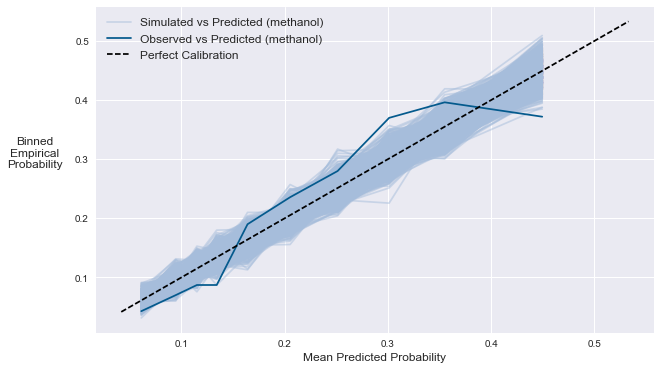

In [13]:
reload(viz)
current_fuel = 'methanol'
filter_idx = np.where((car_df.fuel_type == current_fuel).values)[0]
# current_probs = simulated_probs[filter_idx, :]
current_probs = car_mnl.long_fitted_probs[filter_idx]
current_choices = car_mnl.choices[filter_idx]
current_sim_y = likelihood_sim_y[filter_idx, :]
current_line_label = 'Observed vs Predicted ({})'.format(current_fuel)
current_sim_label = 'Simulated vs Predicted ({})'.format(current_fuel)

current_sim_color = '#a6bddb'
current_obs_color = '#045a8d'

# viz.plot_binned_reliability(
#     current_probs,
#     current_choices,
#     sim_y=current_sim_y,
#     line_label=current_line_label,
#     line_color=current_obs_color,
#     sim_label=current_sim_label,
#     sim_line_color=current_sim_color,
#     figsize=(10, 6),
#     ref_line=True,
#     output_file='../reports/figures/reliability-plot-vehicle-choice-mnl-methanol-point.pdf')

viz.plot_binned_reliability(
    current_probs,
    current_choices,
    sim_y=current_sim_y,
    line_label=current_line_label,
    line_color=current_obs_color,
    sim_label=current_sim_label,
    sim_line_color=current_sim_color,
    figsize=(10, 6),
    ref_line=True,
    output_file=None)

###  4. Binned Marginal Model Plot

Plotting: 100%|██████████| 1000/1000 [00:03<00:00, 252.55it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


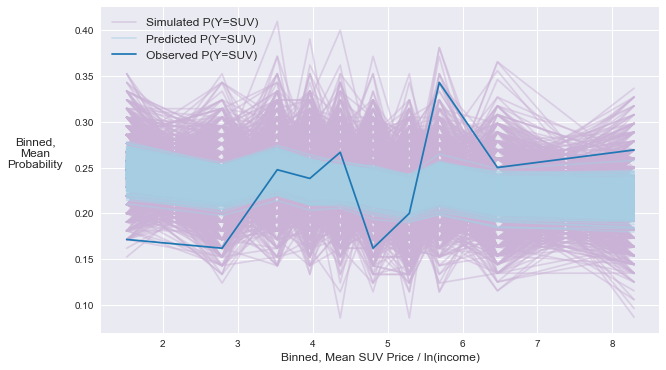

In [14]:
current_body = 'sportuv'
selection_idx = (car_df.body_type == current_body).values

num_traces = 500
current_probs = simulated_probs[selection_idx]
current_y = car_df.loc[selection_idx, 'choice'].values
current_x = car_df.loc[selection_idx, 'price_over_log_income'].values
current_sim_y = likelihood_sim_y[selection_idx]

# filename =\
#     '../reports/figures/marginal-model-plot-vehicle-choice-mnl-suv.pdf'
filename = None
viz.make_binned_marginal_model_plot(current_probs,
                                    current_y,
                                    current_x,
                                    partitions=10,
                                    sim_y=current_sim_y,
                                    y_label='Observed P(Y=SUV)',
                                    prob_label='Predicted P(Y=SUV)',
                                    sim_label='Simulated P(Y=SUV)',
                                    x_label='Binned, Mean SUV Price / ln(income)',
                                    alpha=0.5,
                                    figsize=(10, 6),
                                    output_file=filename)

In [22]:
from sklearn.ensemble import (RandomForestClassifier, 
                              ExtraTreesClassifier,
                              RandomForestRegressor,
                              ExtraTreesRegressor)

def make_bagger(X, Y,
                n_estimators=25,
                min_samples_leaf=10,
                random_state=None):
    if not isinstance(X, np.ndarray) or len(X.shape) != 1:
        msg = 'X MUST be a 1D ndarray'
        raise ValueError(msg)
    if not isinstance(Y, np.ndarray) or len(Y.shape) != 1:
        msg = 'Y MUST be a 1D ndarray'
        raise ValueError(msg)
    if ((Y < 1.0) & (Y > 0)).any():
#         clf = RandomForestRegressor(
#                   n_estimators=n_estimators,
#                   min_samples_leaf=min_samples_leaf,
#                   max_features=1,
#                   random_state=random_state)
        clf = ExtraTreesRegressor(
                  n_estimators=n_estimators,
                  min_samples_leaf=min_samples_leaf,
                  max_features=1,
                  random_state=random_state)
    else:
#         clf = RandomForestClassifier(
#                   n_estimators=n_estimators,
#                   min_samples_leaf=min_samples_leaf,
#                   max_features=1,
#                   random_state=random_state)
        clf = ExtraTreesClassifier(
                  n_estimators=n_estimators,
                  min_samples_leaf=min_samples_leaf,
                  max_features=1,
                  random_state=random_state)
    
    clf.fit(X[:, None], Y)
    return clf


def _plot_x_vs_bagged_y(x_vals,
                        y_vals,
                        color,
                        alpha,
                        label,
                        ax,
                        random_state=111):
    # Create the bagging classifier
    bagger = make_bagger(x_vals, y_vals, random_state=random_state)
    # Get the bagging probabilities
    if hasattr(bagger, 'predict_proba'):
        bagged_probs = bagger.predict_proba(x_vals[:, None])[:, 1]
    else:
        bagged_probs = bagger.predict(x_vals[:, None])
    
    # Plot the x_vals versus their predicted probabilities
    ax.plot(x_vals, bagged_probs,
            c=color, alpha=alpha, label=label)
    return None


def make_bagged_marginal_model_plot(probs,
                                    choices,
                                    ref_vals,
                                    sim_y=None,
                                    partitions=10,
                                    y_color=None,
                                    prob_color=None,
                                    sim_color=None,
                                    y_label='Observed',
                                    prob_label='Predicted',
                                    sim_label='Simulated',
                                    x_label=None,
                                    alpha=None,
                                    title=None,
                                    fontsize=12,
                                    figsize=(5, 3),
                                    fig_and_ax=None,
                                    legend=True,
                                    progress=True,
                                    show=True,
                                    output_file=None,
                                    dpi=500):
    """
    Creates a binned marginal model plot based on the given probability
    predictions, observed outcomes, and refernce values.

    Parameters
    ----------
    probs : 1D or 2D ndarray.
        Each element should be in [0, 1]. There should be 1 column for each
        set of predicted probabilities.
    choices : 1D ndarray.
        Each element should be either a zero or a one. Elements should denote
        whether the alternative corresponding to the given row was chosen or
        not. A 'one' corresponds to a an outcome of 'success'.
    ref_vals : 1D ndarray of floats.
        These should be the elements to plot on the x-axis. `ref_vals` should
        represent a continuous variable. Should have the same number of rows as
        `probs` and `choices`.
    sim_y : 2D ndarray or None, optional.
        Denotes the choices that were simulated based on `probs`. If passed,
        `sim_y.shape` MUST equal `probs.shape` in order to ensure that lines
        are plotted for the simulated choices versus `ref_vals`. This kwarg is
        useful because it shows one the reference distribution of choices
        versus `ref_vals` for choices that actually come from one's model.
        Default = None.
    partitions : positive int.
        Denotes the number of partitions to split one's data into for binning.
    y_color, prob_color, sim_color : matplotlib color, or `None`, optional.
        Determines the color that is used to plot the observed choices,
        predicted probabilities, and simulated choices versus `ref_vals`.
        Default is `None`.
    y_label, prob_label, sim_label : str, or None, optional.
        Denotes the label to be used for the lines relating the observed
        choices, predicted probabilities, and simulated choices to the
        `ref_vals`. Default == ['Observed', 'Predicted', 'Simulated'].
    x_label : str, or None, optional.
        The label for the x-axis of the plot. If None, the x-axis will be
        labeled 'Binned, Mean Reference Values.' Default is `None`.
    alpha : positive float in [0.0, 1.0], or `None`, optional.
        Determines the opacity of the elements drawn on the plot.
        0.0 == transparent and 1.0 == opaque. Default is `None`.
    title : str, or None, optional.
        Denotes the title to be displayed for the plot. Default is None.
    fontsize : int or None, optional.
        The fontsize to be used in the plot. Default is 12.
    figsize : 2-tuple of positive ints.
        Determines the size of the created figure. Default == (5, 3).
    fig_and_ax : list of matplotlib figure and axis, or `None`, optional.
        Determines whether a new figure will be created for the plot or whether
        the plot will be drawn on existing axes. If None, a new figure will be
        created. Default is `None`.
    legend : bool, optional.
        Determines whether a legend is printed for the plot. Default == True.
    progress : bool, optional.
        Determines whether a progressbar is displayed while making the plot.
        Default == True.
    show : bool, optional.
        Determines whether the figure is shown after plotting is complete.
        Default == True.
    output_file : str, or None, optional.
        Denotes the relative or absolute filepath (including the file format)
        that is to be used to save the plot. If None, the plot will not be
        saved to file. Default is None.
    dpi : positive int, optional.
        Denotes the number of 'dots per inch' for the saved figure. Will only
        be used if `output_file is not None`. Default == 500.

    Returns
    -------
    None.
    """
    # Make probs 2D if necessary
    probs = probs[:, None] if probs.ndim == 1 else probs

    # Sort the arguments, if necesssary
    sort_order = np.argsort(ref_vals)
    ref_vals = ref_vals[sort_order]
    probs = probs[sort_order, :]
    choices = choices[sort_order]
    if sim_y is not None:
        sim_y = sim_y[sort_order, :]

    # Create the figure and axes if need be
    if fig_and_ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
        fig_and_ax = [fig, ax]
    else:
        fig, ax = fig_and_ax

    # Choose colors for the plot if necesssary
    if y_color is None:
        y_color =\
            (0.12156862745098039, 0.47058823529411764, 0.7058823529411765)
    if prob_color is None:
        prob_color =\
            (0.6509803921568628, 0.807843137254902, 0.8901960784313725)
    if sim_color is None:
        sim_color =\
            (0.792156862745098, 0.6980392156862745, 0.8392156862745098)

    # Create the progressbar iterator if desired
    if progress:
        description = "Plotting" if sim_y is None else "Plotting Simulations"
        prob_iterator = viz.PROGRESS(range(probs.shape[1]), desc=description)
    else:
        prob_iterator = range(probs.shape[1])

    #####
    # Plot the simulated reliability curves, if desired
    #####
    if sim_y is not None:
        for i in prob_iterator:
            current_label = sim_label if i == 0 else None
            _plot_x_vs_bagged_y(ref_vals,
                                sim_y[:, i],
                                sim_color,
                                alpha,
                                current_label,
                                ax,
                                random_state=111)

    # Create the progressbar iterator if desired
    if progress:
        prob_iterator = viz.PROGRESS(range(probs.shape[1]), desc="Plotting")
    else:
        prob_iterator = range(probs.shape[1])

    #####
    # Plot the probabilities versus the ref values.
    #####
    for col in prob_iterator:
        # Get the current line label and probabilities
        current_label = prob_label if col == 0 else None
        current_probs = probs[:, col]


        _plot_x_vs_bagged_y(ref_vals,
                            current_probs,
                            prob_color,
                            alpha,
                            current_label,
                            ax,
                            random_state=111)
    #####
    # Plot choices versus ref_vals
    #####
    # Make sure the 'true' relationship is not transparent
    observed_alpha = 1.0
    _plot_x_vs_bagged_y(ref_vals,
                        choices,
                        y_color,
                        observed_alpha,
                        y_label,
                        ax,
                        random_state=111)

    # Label the plot axes
    if x_label is None:
        ax.set_xlabel('Binned, Mean Reference Values', fontsize=fontsize)
    else:
        ax.set_xlabel(x_label, fontsize=fontsize)
    ax.set_ylabel('Binned,\nMean\nProbability',
                  fontsize=fontsize, rotation=0, labelpad=40)

    # Make the title if desired
    if title is not None:
        ax.set_title(title, fontsize=fontsize)

    # Make the legend, if desired
    if legend:
        ax.legend(loc='best', fontsize=fontsize)

    # Despine the plot
    sbn.despine()

    # Save the plot if desired
    if output_file is not None:
        fig.tight_layout()
        fig.savefig(output_file, dpi=dpi, bbox_inches='tight')

    # Show the plot if desired
    if show:
        fig.show()
    return None


Plotting: 100%|██████████| 1000/1000 [01:10<00:00, 11.90it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


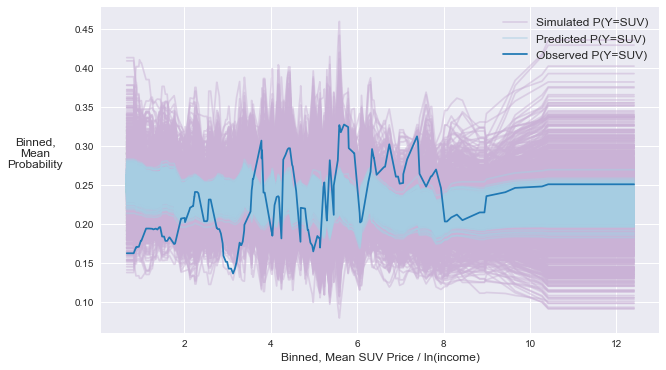

In [23]:
current_body = 'sportuv'
selection_idx = (car_df.body_type == current_body).values

num_traces = 500
current_probs = simulated_probs[selection_idx]
current_y = car_df.loc[selection_idx, 'choice'].values
current_x = car_df.loc[selection_idx, 'price_over_log_income'].values
current_sim_y = likelihood_sim_y[selection_idx]

# filename =\
#     '../reports/figures/marginal-model-plot-vehicle-choice-mnl-suv.pdf'
filename = None
make_bagged_marginal_model_plot(current_probs,
                                current_y,
                                current_x,
                                partitions=10,
                                sim_y=current_sim_y,
                                y_label='Observed P(Y=SUV)',
                                prob_label='Predicted P(Y=SUV)',
                                sim_label='Simulated P(Y=SUV)',
                                x_label='Binned, Mean SUV Price / ln(income)',
                                alpha=0.5,
                                figsize=(10, 6),
                                output_file=filename)

Plotting: 100%|██████████| 1000/1000 [01:52<00:00,  8.86it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


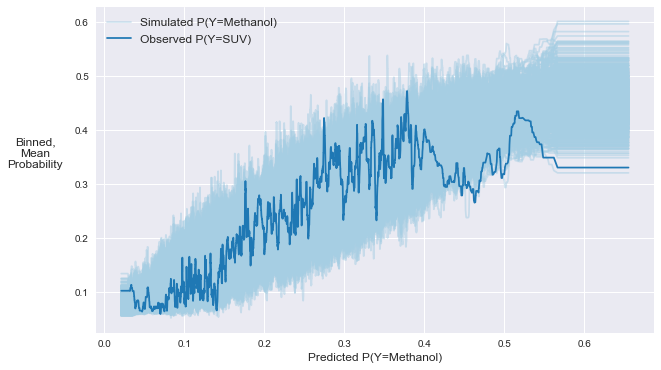

In [27]:
current_fuel = 'methanol'
filter_idx = np.where((car_df.fuel_type == current_fuel).values)[0]
# current_probs = simulated_probs[filter_idx, :]
current_probs = car_mnl.long_fitted_probs[filter_idx]
current_choices = car_mnl.choices[filter_idx]
current_sim_y = likelihood_sim_y[filter_idx, :]

# filename =\
#     '../reports/figures/marginal-model-plot-vehicle-choice-mnl-suv.pdf'
filename = None
make_bagged_marginal_model_plot(current_sim_y,
                                current_choices,
                                current_probs,
                                y_label='Observed P(Y=SUV)',
                                prob_label='Simulated P(Y=Methanol)',
                                x_label='Predicted P(Y=Methanol)',
                                alpha=0.5,
                                figsize=(10, 6),
                                output_file=filename)

### 5. Simulated Histogram

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


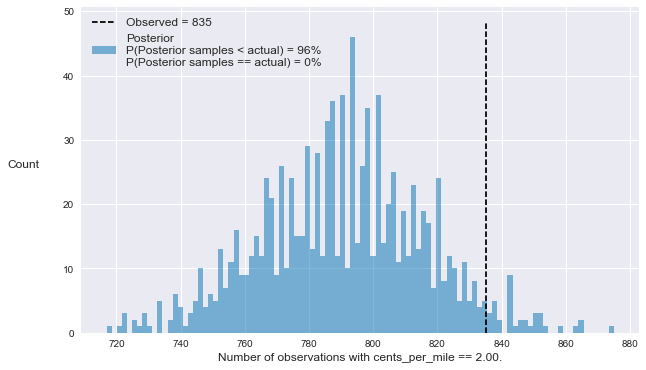

In [28]:
reload(viz)

filter_row = ((car_df.body_type == 'regcar') &
              (car_df.cents_per_mile == 2))
# current_title = 'Num Observations by Cents per Mile for Body = {}'
current_title = ''
# filename =\
#     '../reports/figures/histogram-vehicle-choice-mnl-regcar-operating-costs.pdf'
filename = None
viz.plot_categorical_predictive_densities(
    car_df,
    None,
    likelihood_sim_y,
    'cents_per_mile',
    filter_row,
    car_mnl.choices,
    title=current_title.format('Regular Car'),
    filter_name='observations',
    post_color=sbn.color_palette('colorblind')[0],
    figsize=(10, 6),
    legend_loc='upper left',
    output_file=filename)

### 6. Simulated KDE

Calculating KDEs: 100%|██████████| 500/500 [00:02<00:00, 175.23it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


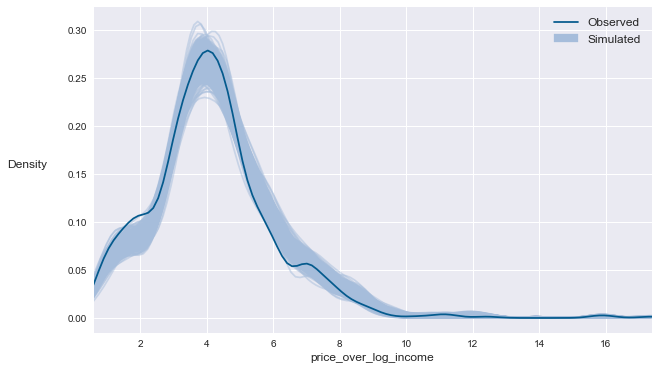

In [29]:
reload(viz)
current_fuel = 'electric'
filter_row = car_df.fuel_type == current_fuel
# current_title = 'KDE of Price/log(income) for {} vehicles'
current_title = ''
filename = None

viz.plot_simulated_kde_traces(likelihood_sim_y,
                              car_df,
                              filter_row,
                              'price_over_log_income',
                              'choice',
                              title=current_title.format(current_fuel),
                              figsize=(10, 6),
                              label='Simulated',
                              n_traces=500,
                              output_file=filename)

### 7. Simulated CDF

Calculating CDFs: 100%|██████████| 1000/1000 [00:03<00:00, 264.24it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


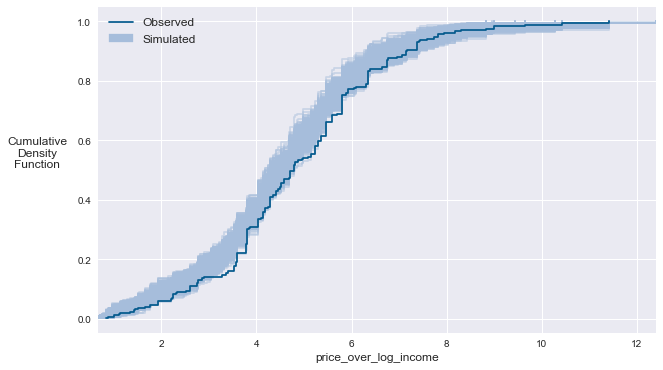

In [30]:
reload(viz)
current_body = 'sportuv'
filter_row = car_df.body_type == current_body
# current_title =\
#     'CDF of Price/log(income) for Sport Utility Vehicles'
current_title = ''
# filename =\
#     '../reports/figures/cdf-vehicle-choice-mnl-suv-price.pdf'
filename = None

viz.plot_simulated_cdf_traces(likelihood_sim_y,
                              car_df,
                              filter_row,
                              'price_over_log_income',
                              'choice',
                              label='Simulated',
                              title=current_title,
                              figsize=(10, 6),
                              output_file=filename)

## Sandbox:
Look at additional plots.

Plotting: 100%|██████████| 1000/1000 [01:38<00:00, 10.13it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1000/1000 [01:09<00:00, 14.33it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1000/1000 [01:22<00:00, 11.68it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1000/1000 [01:23<00:00, 11.99it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py

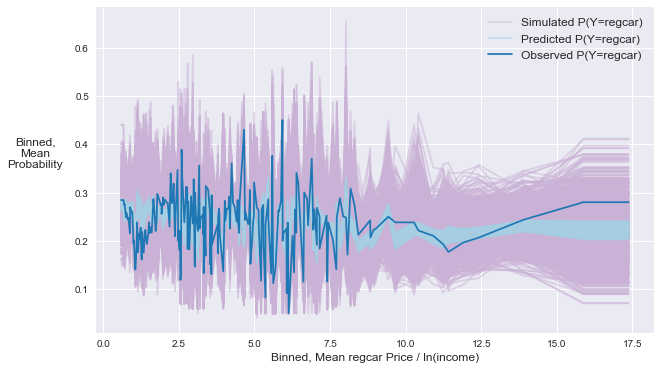

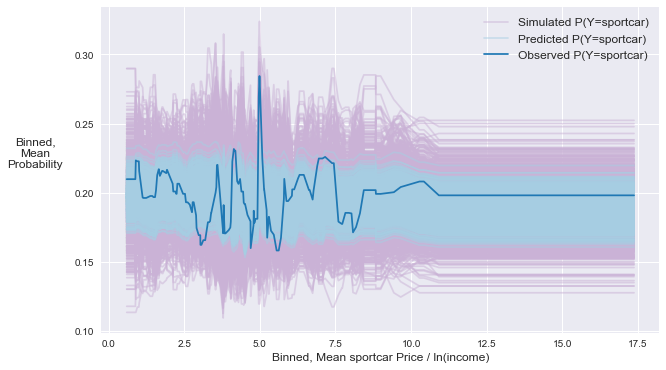

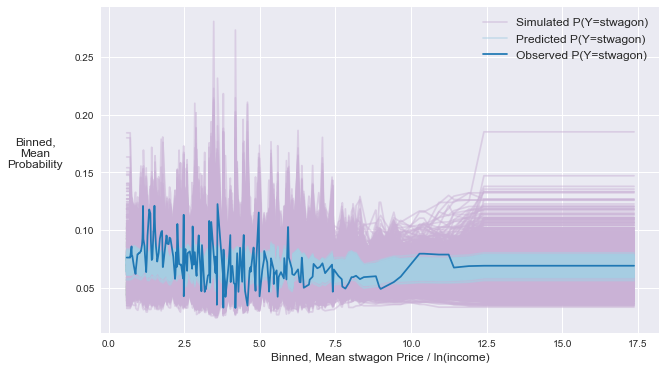

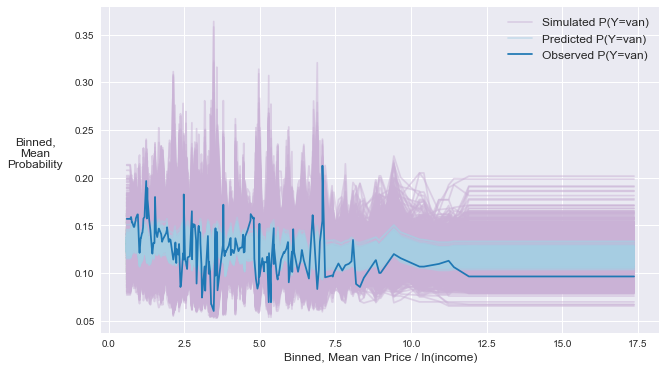

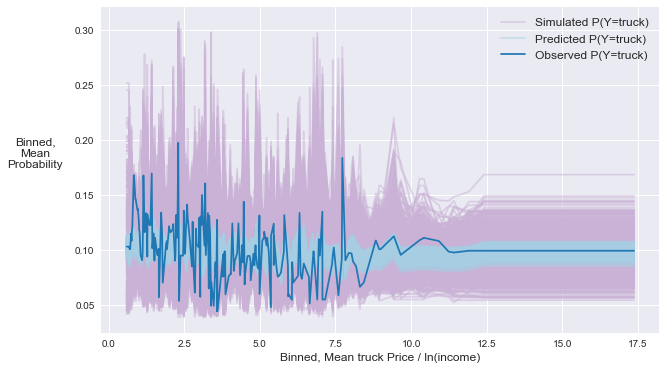

In [31]:
for body in ['regcar', 'sportcar', 'stwagon', 'van', 'truck']:
    current_body = body
    selection_idx = (car_df.body_type == current_body).values

    num_traces = 500
    current_probs = simulated_probs[selection_idx]
    current_y = car_df.loc[selection_idx, 'choice'].values
    current_x = car_df.loc[selection_idx, 'price_over_log_income'].values
    current_sim_y = likelihood_sim_y[selection_idx]

    filename = None

    make_bagged_marginal_model_plot(current_probs,
                                    current_y,
                                    current_x,
                                    partitions=10,
                                    sim_y=current_sim_y,
                                    y_label='Observed P(Y={})'.format(body),
                                    prob_label='Predicted P(Y={})'.format(body),
                                    sim_label='Simulated P(Y={})'.format(body),
                                    x_label='Binned, Mean {} Price / ln(income)'.format(body),
                                    alpha=0.5,
                                    figsize=(10, 6),
                                    output_file=filename)

Calculating CDFs: 100%|██████████| 1000/1000 [00:05<00:00, 174.53it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Calculating CDFs: 100%|██████████| 1000/1000 [00:03<00:00, 252.95it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Calculating CDFs: 100%|██████████| 1000/1000 [00:03<00:00, 263.01it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Calculating CDFs: 100%|██████████| 1000/1000 [00:04<00:00, 248.40it/s]
/Users/timothyb0912/anaconda/lib/python2.

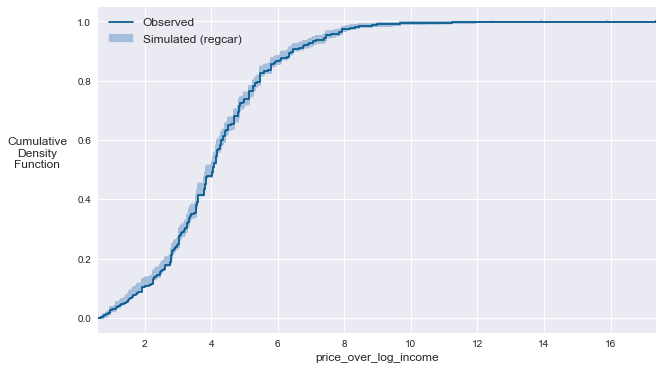

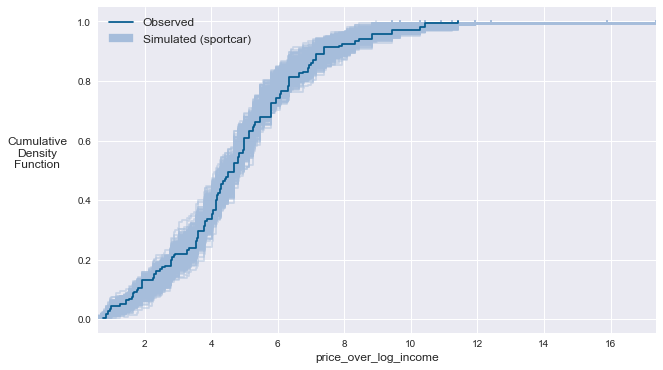

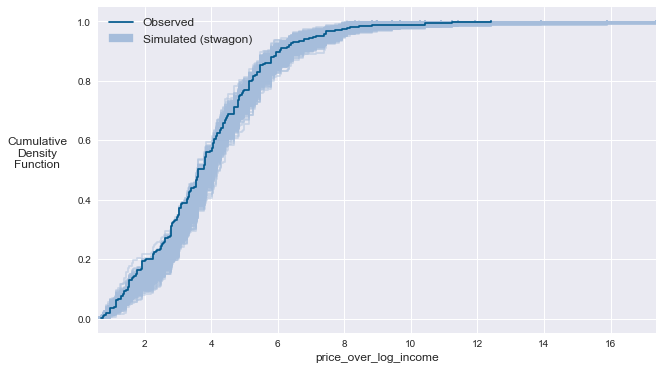

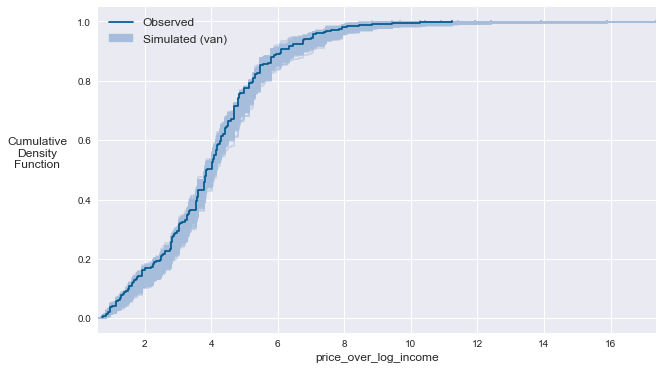

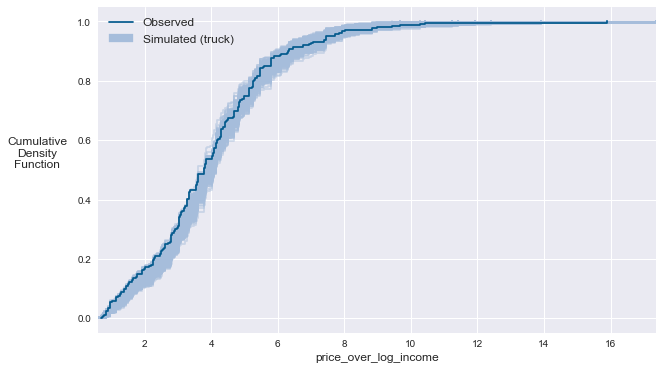

In [32]:
for body in ['regcar', 'sportcar', 'stwagon', 'van', 'truck']:
    current_body = body
    filter_row = car_df.body_type == current_body
    # current_title =\
    #     'CDF of Price/log(income) for Sport Utility Vehicles'
    current_title = ''
    filename = None
    viz.plot_simulated_cdf_traces(likelihood_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  label='Simulated ({})'.format(body),
                                  title=current_title,
                                  figsize=(10, 6),
                                  output_file=filename)

Plotting: 100%|██████████| 1000/1000 [02:05<00:00,  7.95it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1000/1000 [01:27<00:00,  6.53it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1000/1000 [01:37<00:00, 10.24it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py

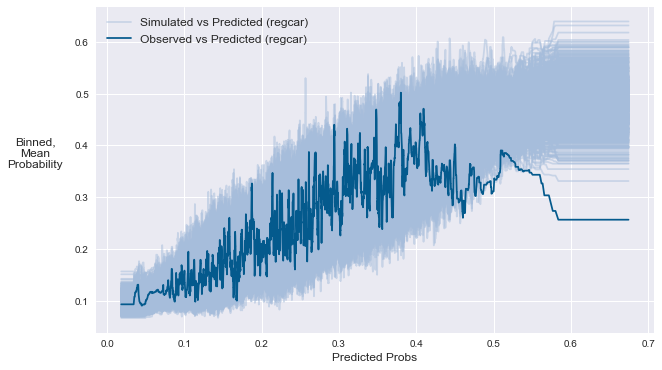

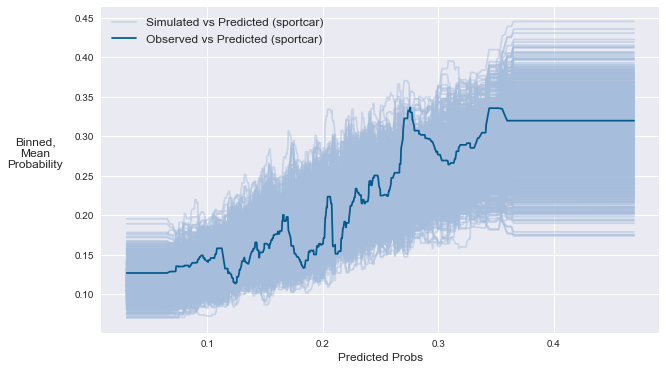

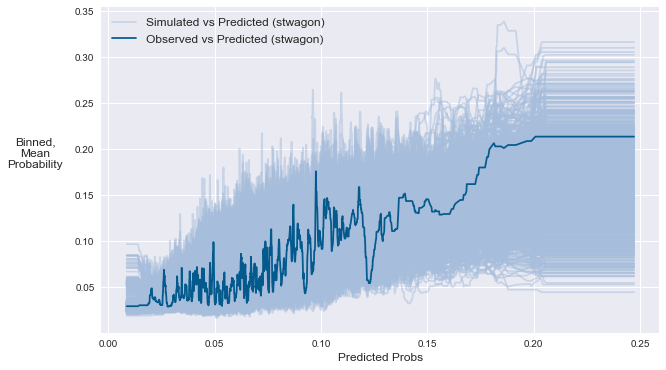

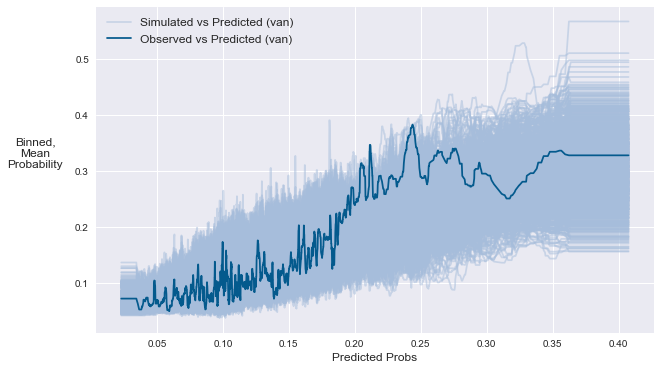

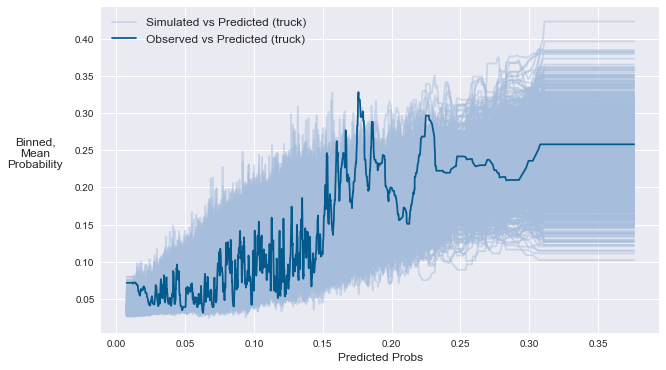

In [34]:
for body in ['regcar', 'sportcar', 'stwagon', 'van', 'truck']:
    filter_idx = (car_df.body_type == body).values
    current_probs = car_mnl.long_fitted_probs[filter_idx]
    current_choices = car_mnl.choices[filter_idx]
    current_sim_y = likelihood_sim_y[filter_idx, :]
    current_line_label = 'Observed vs Predicted ({})'.format(body)
    current_sim_label = 'Simulated vs Predicted ({})'.format(body)

    current_sim_color = '#a6bddb'
    current_obs_color = '#045a8d'

    reliability_path = None
    make_bagged_marginal_model_plot(current_sim_y,
                                    current_choices,
                                    current_probs,
                                    y_label=current_line_label,
                                    prob_label=current_sim_label,
                                    x_label='Predicted Probs',
                                    y_color=current_obs_color,
                                    prob_color=current_sim_color,
                                    alpha=0.5,
                                    figsize=(10, 6),
                                    output_file=reliability_path)

Plotting: 100%|██████████| 1000/1000 [02:01<00:00,  8.02it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1000/1000 [01:58<00:00,  8.14it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Plotting: 100%|██████████| 1000/1000 [01:56<00:00,  9.01it/s]
/Users/timothyb0912/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


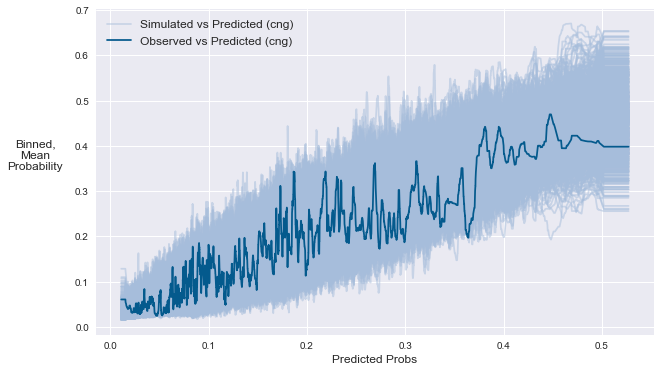

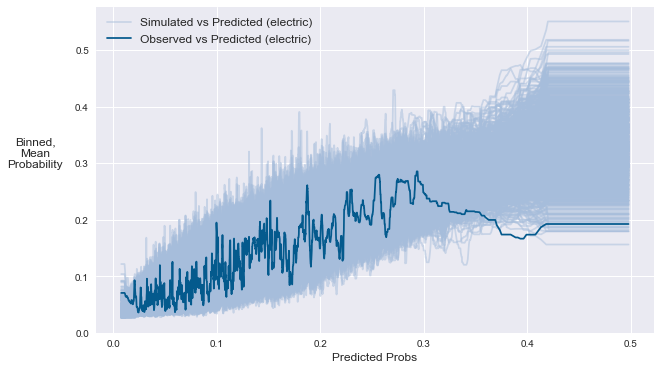

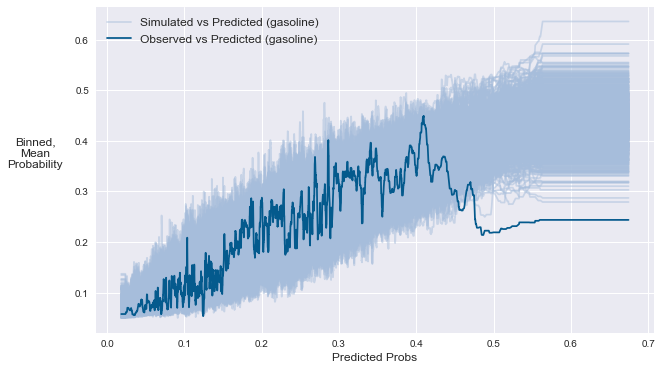

In [33]:
for fuel in ['cng', 'electric', 'gasoline']:
    current_fuel = fuel
    filter_idx = np.where((car_df.fuel_type == current_fuel).values)[0]
    current_probs = car_mnl.long_fitted_probs[filter_idx]
    current_choices = car_mnl.choices[filter_idx]
    current_sim_y = likelihood_sim_y[filter_idx, :]
    current_line_label = 'Observed vs Predicted ({})'.format(current_fuel)
    current_sim_label = 'Simulated vs Predicted ({})'.format(current_fuel)

    current_sim_color = '#a6bddb'
    current_obs_color = '#045a8d'

    reliability_path = None
    make_bagged_marginal_model_plot(current_sim_y,
                                    current_choices,
                                    current_probs,
                                    y_label=current_line_label,
                                    prob_label=current_sim_label,
                                    x_label='Predicted Probs',
                                    y_color=current_obs_color,
                                    prob_color=current_sim_color,
                                    alpha=0.5,
                                    figsize=(10, 6),
                                    output_file=reliability_path)

In [3]:
x = [0, 1]
x.extend([2, 3])
print(x)

[0, 1, 2, 3]
